# Interictal Spikes Analysis

In [1]:
import os, re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

SPIKES_OUTPUT_DIR = "../../Data/spikes/devin_spikes/"
SEIZURES_DIR = "../../Data/seizures/source_mat/"
SEIZURE_BUFFER_TIME = 5  # hours

In [2]:
patient_hup_id = 143
fs = 1024

In [3]:
seizure_times_sec = np.load(os.path.join(SEIZURES_DIR, f"HUP_{patient_hup_id}.npy"))
seizure_times_samples = seizure_times_sec * fs
seizure_times_samples = seizure_times_samples.astype(int)
seizure_times_samples

array([[609828311, 609889751],
       [611381135, 611406991],
       [612594739, 612621762],
       [818522163, 818576076]])

In [4]:
# Initialize an empty list to hold the data
data = []

# Iterate through all files in the directory
for filename in os.listdir(SPIKES_OUTPUT_DIR):
    # Check if the file ends with .npy
    if filename.endswith(".npy"):
        # Use regular expression to match the pattern and extract desired numbers
        match = re.match(r"HUP(\d+)_phaseII_(\d+).npy", filename)

        if match:
            current_patient_hup_id = int(match.group(1))
            if current_patient_hup_id != patient_hup_id:
                continue
            interval_index = int(match.group(2))

            # Append the data to the list
            data.append(
                {
                    "filename": filename,
                    "interval_index": interval_index,
                }
            )

# Convert the list of dictionaries to a pandas DataFrame
spike_files_df = pd.DataFrame(data)
# Sort the DataFrame by the interval index
spike_files_df = spike_files_df.sort_values(by="interval_index")
# Reset the index
spike_files_df = spike_files_df.reset_index(drop=True)
# Add a new column called "start_sample_index"
spike_files_df["start_sample_index"] = spike_files_df["interval_index"] * fs * 60 * 2
spike_files_df

,filename,interval_index,start_sample_index
0,HUP143_phaseII_150.npy,150,18432000
1,HUP143_phaseII_156.npy,156,19169280
2,HUP143_phaseII_157.npy,157,19292160
3,HUP143_phaseII_158.npy,158,19415040
4,HUP143_phaseII_159.npy,159,19537920
...,...,...,...
6694,HUP143_phaseII_7163.npy,7163,880189440
6695,HUP143_phaseII_7164.npy,7164,880312320
6696,HUP143_phaseII_7165.npy,7165,880435200
6697,HUP143_phaseII_7166.npy,7166,880558080


In [5]:
# Initialize an empty list to store individual DataFrames
dfs = []

for index, row in spike_files_df.iterrows():
    filename = row["filename"]
    start_sample_index = row["start_sample_index"]

    # Load the data
    spike_data = np.load(os.path.join(SPIKES_OUTPUT_DIR, filename))

    # Convert all values to int
    spike_data = spike_data.astype(int)

    # Adjust the start_sample_index
    spike_data[:, 0] += start_sample_index

    # Convert the modified spike_data to a DataFrame and append to the dfs list
    dfs.append(
        pd.DataFrame(
            spike_data,
            columns=["peak_index", "channel_index", "sequence_index"],
        )
    )

# Concatenate all the individual DataFrames into a single DataFrame
all_spikes_df = pd.concat(dfs, ignore_index=True)

all_spikes_df

,peak_index,channel_index,sequence_index
0,18463258,0,0
1,18463258,2,0
2,18463258,1,0
3,18500815,0,1
4,18500815,2,1
...,...,...,...
288922,880797717,2,52
288923,880798082,0,53
288924,880798085,1,53
288925,880802131,1,54


In [6]:
# Calculate the buffer time in samples
buffer_samples = SEIZURE_BUFFER_TIME * 3600 * fs

In [7]:
# # Create a mask to determine which rows to keep
# mask = np.ones(len(all_spikes_df), dtype=bool)
# for start, end in seizure_times_samples:
#     mask &= ~(
#         (all_spikes_df["peak_index"] >= start - buffer_samples)
#         & (all_spikes_df["peak_index"] <= end + buffer_samples)
#     )

# # Use the mask to filter rows
# interictal_spikes_df = all_spikes_df.copy()[mask]

# # reset index
# interictal_spikes_df.reset_index(drop=True, inplace=True)

# interictal_spikes_df

## Raster plot

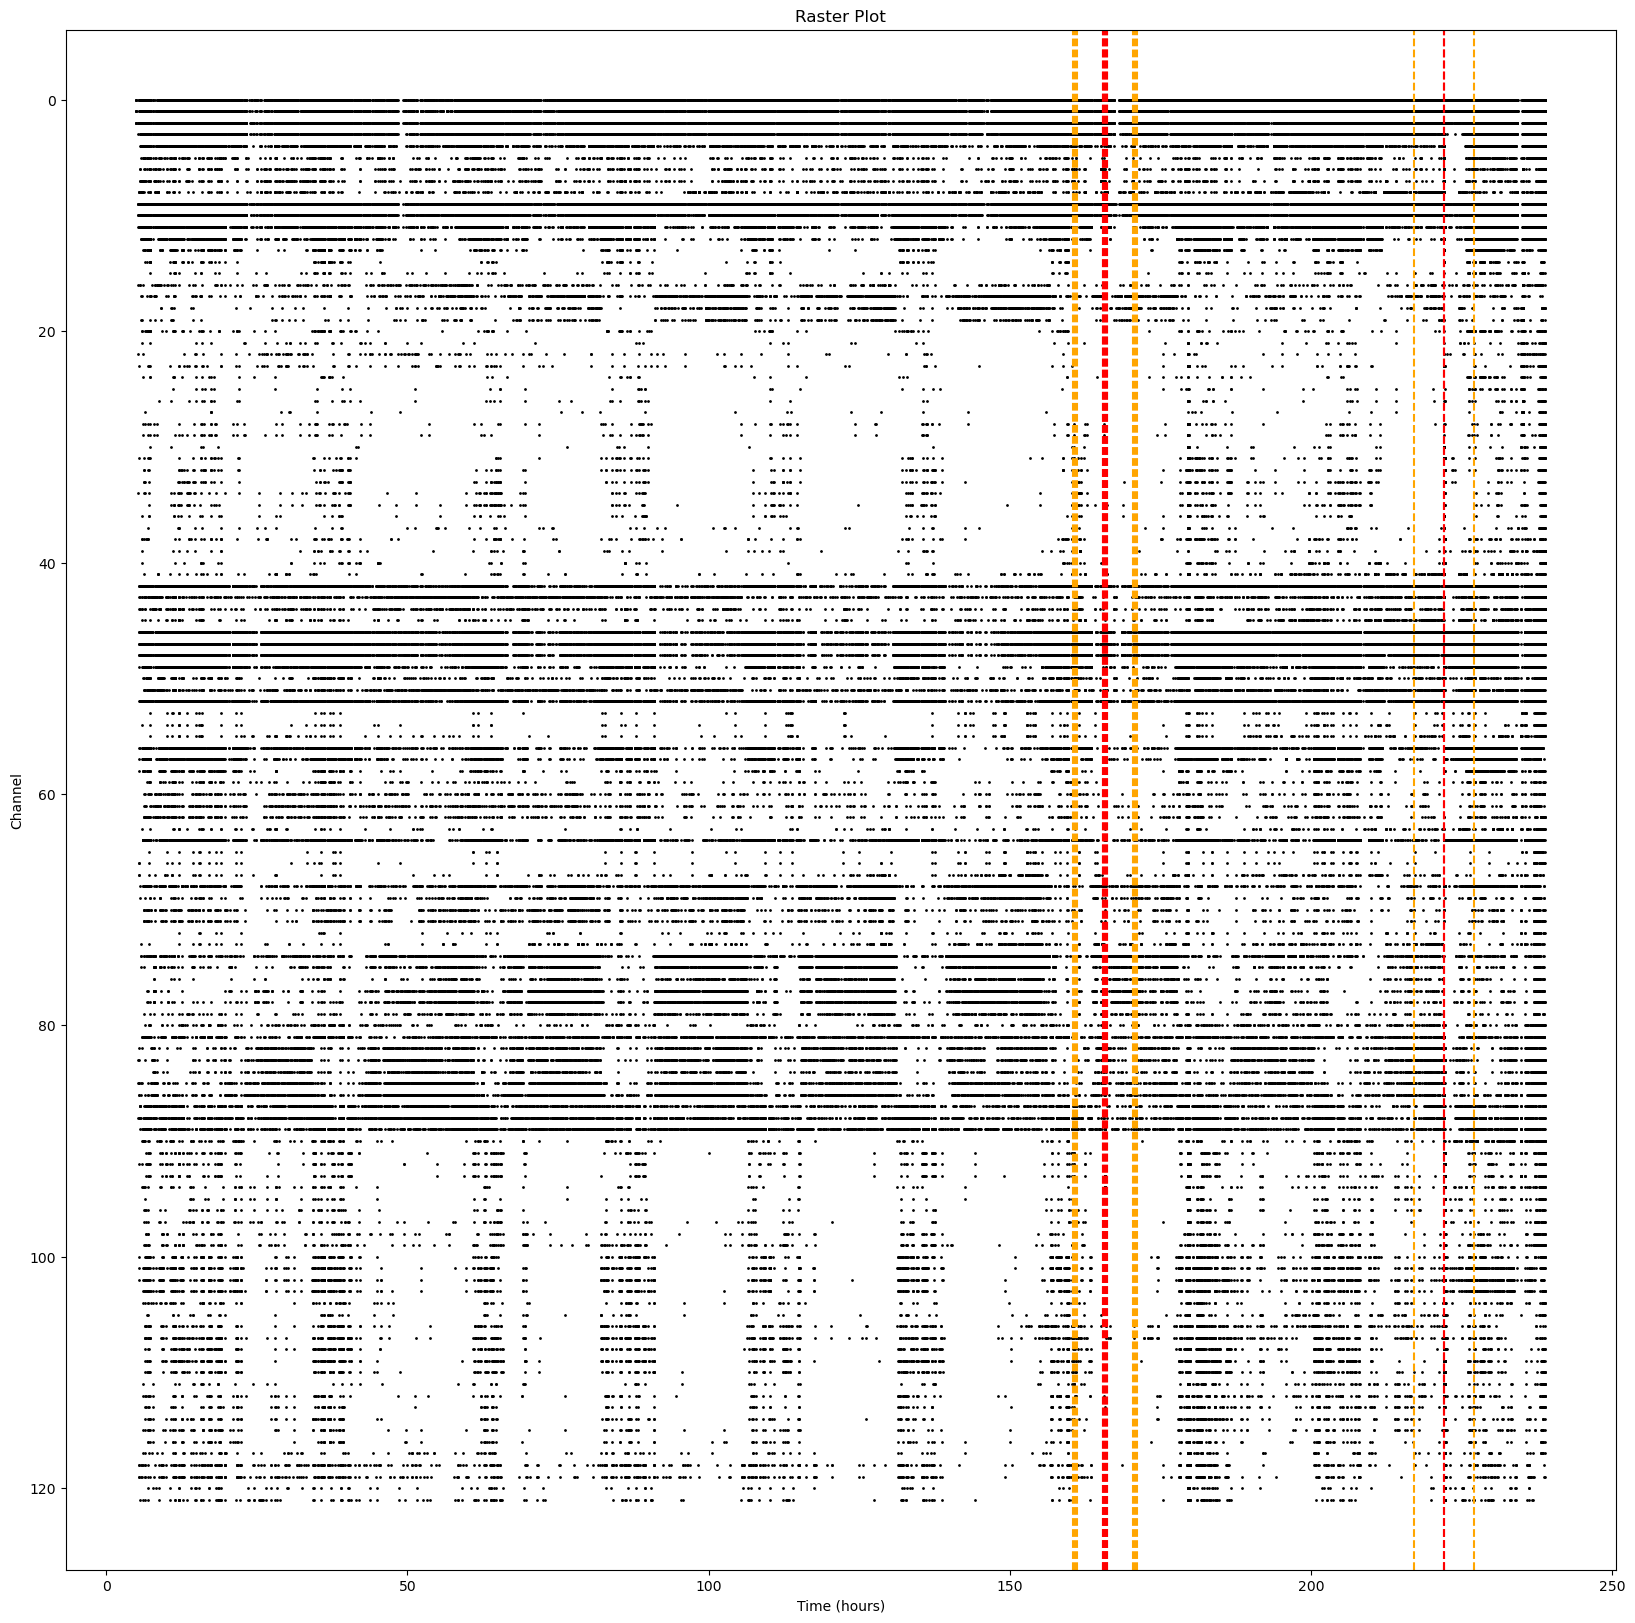

In [8]:
def raster_plot(df, seizure_times, buffer_samples, fs):
    fig, ax = plt.subplots(figsize=(20, 20))
    # Iterate through unique channels
    for channel in df["channel_index"].unique():
        # Extract spike times for this channel
        spike_times = df[df["channel_index"] == channel]["peak_index"]
        spike_times_in_hours = spike_times / (fs * 3600)  # Convert to hours
        ax.plot(spike_times_in_hours, [channel] * len(spike_times), "k.", markersize=2)

    # Plot vertical dashed lines for seizure times
    for start, end in seizure_times:
        ax.axvline(start / (fs * 3600), color="r", linestyle="--")
        ax.axvline(end / (fs * 3600), color="r", linestyle="--")

    # Plot vertical dashed lines for seizure times with buffer
    for start, end in seizure_times:
        ax.axvline(
            (start - buffer_samples) / (fs * 3600), color="orange", linestyle="--"
        )
        ax.axvline((end + buffer_samples) / (fs * 3600), color="orange", linestyle="--")

    ax.set_ylabel("Channel")
    ax.set_xlabel("Time (hours)")
    ax.set_title("Raster Plot")
    ax.invert_yaxis()  # Optional: to have channel 0 at the top
    plt.show()


raster_plot(all_spikes_df, seizure_times_samples, buffer_samples, fs)

## Inter-spike intervals

In [9]:
# Calculate the inter-spike interval
all_spikes_df["inter_spike_interval_samples"] = all_spikes_df["peak_index"].diff()

# If you want to handle the NaN value for the first row (since there's no previous spike to compare to):
all_spikes_df.loc[0, "inter_spike_interval_samples"] = 0  # or any other suitable value

# Convert the inter_spike_interval_samples column to integer
all_spikes_df["inter_spike_interval_samples"] = all_spikes_df[
    "inter_spike_interval_samples"
].astype(int)

all_spikes_df["inter_spike_interval_sec"] = (
    all_spikes_df["inter_spike_interval_samples"] / fs
).astype(int)

all_spikes_df.head(50)

# print the last 50 rows
all_spikes_df.tail(50)

,peak_index,channel_index,sequence_index,inter_spike_interval_samples,inter_spike_interval_sec
288877,880772163,40,42,10808,10
288878,880772166,44,42,3,0
288879,880772168,45,42,2,0
288880,880775207,44,43,3039,2
288881,880775209,45,43,2,0
288882,880775288,40,43,79,0
288883,880778580,40,44,3292,3
288884,880778585,44,44,5,0
288885,880778586,45,44,1,0
288886,880783006,40,45,4420,4


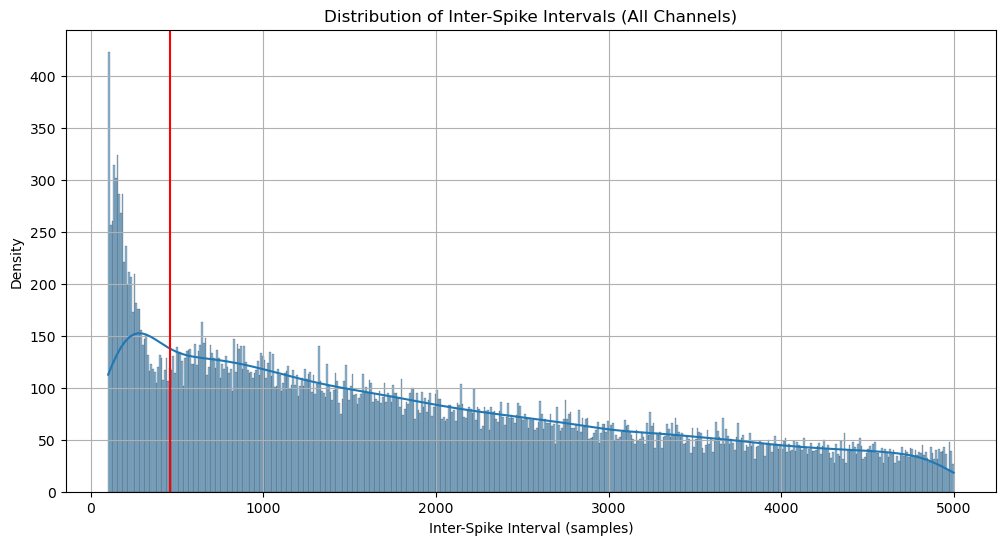

In [10]:
# Create a copy of all_spikes_df called all_spikes_df_copy_2

all_spikes_df_copy_2 = all_spikes_df.copy()

all_spikes_df_copy_2 = all_spikes_df_copy_2[
    all_spikes_df_copy_2["inter_spike_interval_samples"] > 100
]
all_spikes_df_copy_2 = all_spikes_df_copy_2[
    all_spikes_df_copy_2["inter_spike_interval_samples"] < 5000
]

plt.figure(figsize=(12, 6))
sns.histplot(all_spikes_df_copy_2["inter_spike_interval_samples"], kde=True, bins=500)
plt.title("Distribution of Inter-Spike Intervals (All Channels)")
plt.xlabel("Inter-Spike Interval (samples)")
plt.ylabel("Density")
# Plot a vertical red line at 500
plt.axvline(x=460, color="red")
plt.grid(True)
plt.show()

In [11]:
# Convert peak_index to hour
all_spikes_df["hour"] = all_spikes_df["peak_index"] // (fs * 3600)
all_spikes_df.head()

,peak_index,channel_index,sequence_index,inter_spike_interval_samples,inter_spike_interval_sec,hour
0,18463258,0,0,0,0,5
1,18463258,2,0,0,0,5
2,18463258,1,0,0,0,5
3,18500815,0,1,37557,36,5
4,18500815,2,1,0,0,5


In [12]:
# Get the rows where hour is 20
all_spikes_df[all_spikes_df["hour"] == 20]

,peak_index,channel_index,sequence_index,inter_spike_interval_samples,inter_spike_interval_sec,hour
26380,73867096,10,0,161143,157,20
26381,73867190,88,0,94,0,20
26382,73894665,0,1,27475,26,20
26383,73894714,1,1,49,0,20
26384,73894720,2,1,6,0,20
...,...,...,...,...,...,...
26662,77357051,59,5,60,0,20
26663,77357051,60,5,0,0,20
26664,77410846,1,6,53795,52,20
26665,77410856,9,6,10,0,20


In [13]:
all_spikes_df["sequence_index_mask"] = (
    (all_spikes_df["sequence_index"].diff() != 0).astype(int).cumsum()
)
# Drop sequence_index column
all_spikes_df.drop(columns=["sequence_index"], inplace=True)

In [14]:
# Identify the first spike in each sequence
first_spikes = all_spikes_df.groupby("sequence_index_mask").first().reset_index()
print("Number of first spikes: ", len(first_spikes))
first_spikes.head(20)

Number of first spikes:  72887


,sequence_index_mask,peak_index,channel_index,inter_spike_interval_samples,inter_spike_interval_sec,hour
0,1,18463258,0,0,0,5
1,2,18500815,0,37557,36,5
2,3,18510874,2,10059,9,5
3,4,18549988,2,39114,38,5
4,5,19200630,2,650642,635,5
5,6,19394884,83,53175,51,5
6,7,19461910,88,66924,65,5
7,8,19902779,52,34157,33,5
8,9,19930747,8,27940,27,5
9,10,19935316,0,4537,4,5


In [15]:
# Filter out the first spikes
filtered_df = pd.concat([all_spikes_df, first_spikes]).drop_duplicates(keep=False)
assert len(filtered_df) == len(all_spikes_df) - len(first_spikes)
filtered_df.head(20)

,peak_index,channel_index,inter_spike_interval_samples,inter_spike_interval_sec,hour,sequence_index_mask
1,18463258,2,0,0,5,1
2,18463258,1,0,0,5,1
4,18500815,2,0,0,5,2
5,18500815,1,0,0,5,2
7,18510874,0,0,0,5,3
8,18510874,1,0,0,5,3
10,18549988,1,0,0,5,4
11,18549988,0,0,0,5,4
13,19200631,10,1,0,5,5
14,19200633,3,2,0,5,5


In [16]:
# Get the columns in filtered_df where hour is 20
filtered_df[filtered_df["hour"] == 20]

,peak_index,channel_index,inter_spike_interval_samples,inter_spike_interval_sec,hour,sequence_index_mask
26380,73867096,10,161143,157,20,6203
26381,73867190,88,94,0,20,6203
26383,73894714,1,49,0,20,6204
26384,73894720,2,6,0,20,6204
26386,73894866,85,2,0,20,6205
...,...,...,...,...,...,...
26661,77356991,48,0,0,20,6279
26662,77357051,59,60,0,20,6279
26663,77357051,60,0,0,20,6279
26665,77410856,9,10,0,20,6280


In [17]:
# Group by hour to calculate average inter_spike_interval_samples for the same spike train
avg_intervals = (
    filtered_df.groupby("hour")["inter_spike_interval_samples"].mean().reset_index()
)
avg_intervals.head(20)

,hour,inter_spike_interval_samples
0,5,2015.566667
1,6,8.125169
2,7,321.410311
3,8,103.387302
4,9,8.554196
5,10,225.220313
6,11,236.725683
7,12,7.972743
8,13,334.549892
9,14,7.482054


In [18]:
# Drop the rows in avg_intervalswhere inter_spike_interval_samples is above 100
avg_intervals = avg_intervals[avg_intervals["inter_spike_interval_samples"] < 10]
avg_intervals.head(20)

,hour,inter_spike_interval_samples
1,6,8.125169
4,9,8.554196
7,12,7.972743
9,14,7.482054
11,16,7.756458
12,17,7.698852
29,34,8.791148
30,35,7.945339
32,37,8.002655
40,45,9.697491


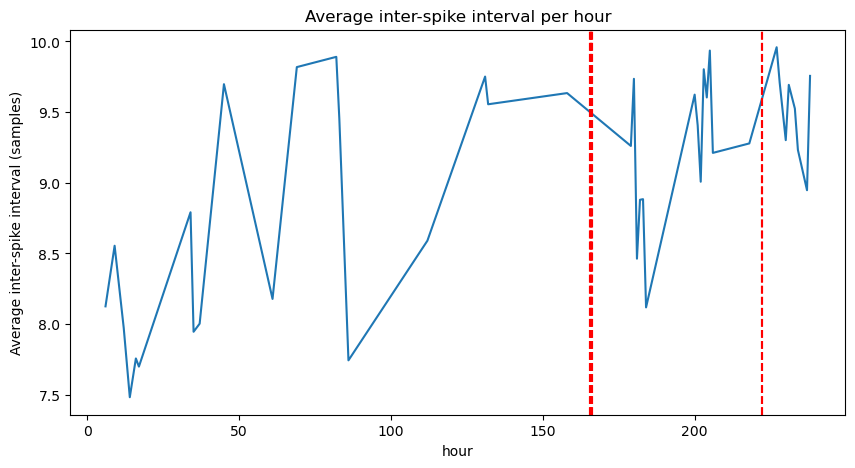

In [19]:
# Plot hour and inter_spike_interval_samples in avg_intervals
plt.plot(avg_intervals["hour"], avg_intervals["inter_spike_interval_samples"])

# Plot vertical lines indicating seizure times
for start, end in seizure_times_samples:
    plt.axvline(start / (fs * 3600), color="r", linestyle="--")
    plt.axvline(end / (fs * 3600), color="r", linestyle="--")

plt.xlabel("hour")
plt.ylabel("Average inter-spike interval (samples)")
plt.title("Average inter-spike interval per hour")

# Make the plot wider
plt.gcf().set_size_inches(10, 5)
plt.show()

## Spike Cascade Size Distribution